In [83]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from datetime import datetime as dt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [219]:
data = pd.read_csv('UNRATE.csv',header=None)
data.head()

,0,1
0,01-01-1948,3.4
1,01-02-1948,3.8
2,01-03-1948,4.0
3,01-04-1948,3.9
4,01-05-1948,3.5


In [220]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 867 entries, 0 to 866
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       867 non-null    object 
 1   1       867 non-null    float64
dtypes: float64(1), object(1)
memory usage: 13.7+ KB


In [221]:
data.isnull().sum()/data.shape[0]

0    0.0
1    0.0
dtype: float64

In [222]:
data.columns = ['Date','Unrate']

In [223]:
data.Date

0      01-01-1948
1      01-02-1948
2      01-03-1948
3      01-04-1948
4      01-05-1948
          ...    
862    01-11-2019
863    01-12-2019
864    01-01-2020
865    01-02-2020
866    01-03-2020
Name: Date, Length: 867, dtype: object

In [224]:
data.columns = ['Date','Unrate']
#data['Date']=data['Date'].apply(lambda x: x.date())
#data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y', errors='ignore')
data['Date'] = pd.to_datetime(data['Date'])
#data['Date'] = data['Date'].apply(lambda x: dt(int(x[:2]), int(x[3:5]), int(x[6:])))
data['Date'] = data['Date'].dt.date
data = data.set_index('Date').asfreq('D')
#data.Date = pd.DatetimeIndex(data.Date).to_period('M')
data.head(12)

,Unrate
Date,
1948-01-01,3.4
1948-01-02,3.8
1948-01-03,4.0
1948-01-04,3.9
1948-01-05,3.5
1948-01-06,3.6
1948-01-07,3.6
1948-01-08,3.9
1948-01-09,3.8


In [215]:
 data['Date']=data['Date'].apply(lambda x: x.date())

KeyError: 'Date'

In [178]:
data = data.set_index('Date')
data.head(12)

,Unrate
Date,
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5
1948-06-01,3.6
1948-07-01,3.6
1948-08-01,3.9
1948-09-01,3.8


In [225]:
data.shape

(26301, 1)

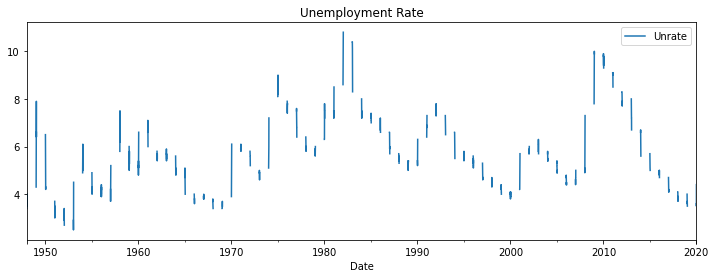

In [226]:
data.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Unemployment Rate')
plt.show(block=False)

## Time series Decomposition

### Additive seasonal decomposition

In [227]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 12, 8
decomposition = sm.tsa.seasonal_decompose(data.Unrate, model='additive') # additive seasonal index
fig = decomposition.plot()
plt.show()

ValueError: This function does not handle missing values

### Multiplicative seasonal decomposition

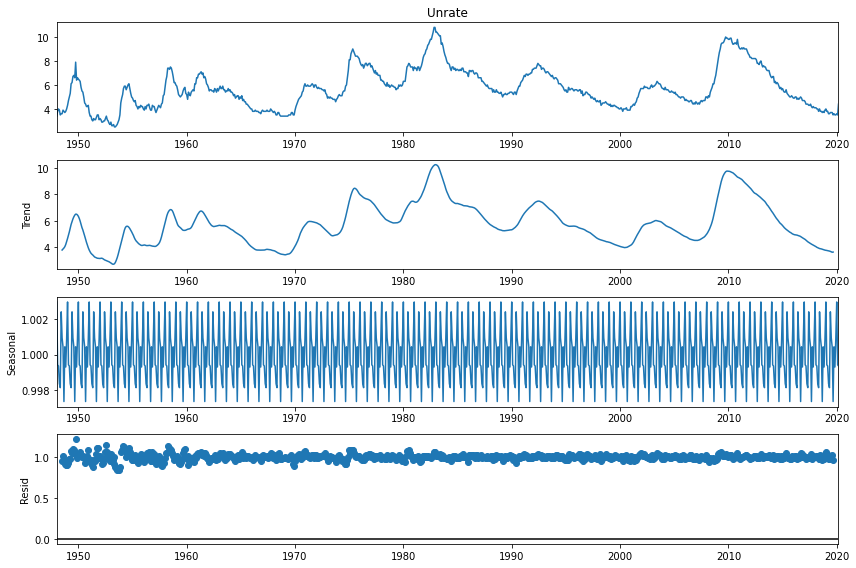

In [145]:
decomposition = sm.tsa.seasonal_decompose(data.Unrate, model='multiplicative') # multiplicative seasonal index
fig = decomposition.plot()
plt.show()

# Build and evaluate time series forecast

## Split time series data into training and test set

In [179]:
train_len = 612
train = data[0:train_len] # first 612 months as training set
test = data[train_len:] # last 255 months as out-of-time test set

### Box Cox transformation to make variance constant

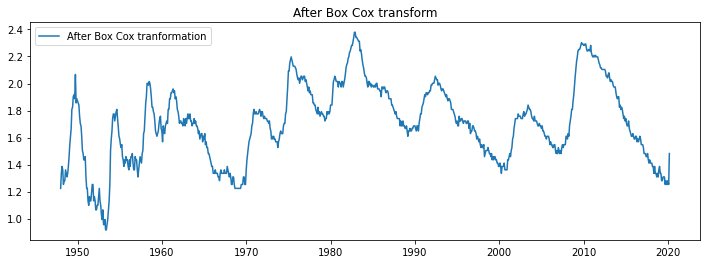

In [180]:
from scipy.stats import boxcox
data_boxcox = pd.Series(boxcox(data['Unrate'], lmbda=0), index = data.index)

plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

### Differencing to remove trend

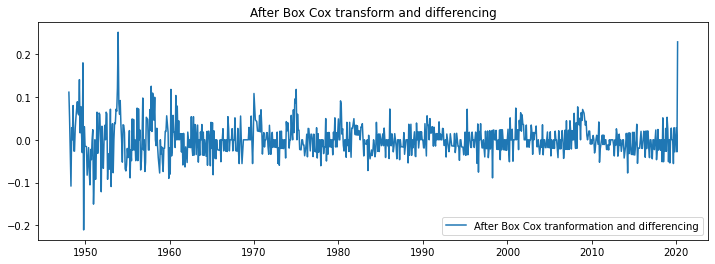

In [181]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), data.index)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox tranformation and differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

In [182]:
data_boxcox_diff.dropna(inplace=True)

In [183]:
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]
train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_data_boxcox_diff = data_boxcox_diff[train_len-1:]

In [184]:
train_data_boxcox_diff

Date
1948-02-01    0.111226
1948-03-01    0.051293
1948-04-01   -0.025318
1948-05-01   -0.108214
1948-06-01    0.028171
                ...   
1998-08-01    0.000000
1998-09-01    0.021979
1998-10-01   -0.021979
1998-11-01   -0.022473
1998-12-01    0.000000
Length: 611, dtype: float64

## Auto regression method (AR)

In [185]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_data_boxcox_diff, order=(12, 0, 0)) 
model_fit = model.fit()
print(model_fit.params)

const       0.000466
ar.L1.y     0.060690
ar.L2.y     0.161198
ar.L3.y     0.118645
ar.L4.y     0.090456
ar.L5.y     0.107079
ar.L6.y     0.008286
ar.L7.y    -0.029412
ar.L8.y     0.032450
ar.L9.y     0.006198
ar.L10.y   -0.124660
ar.L11.y    0.047124
ar.L12.y   -0.148533
dtype: float64


In [186]:
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0])
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])

In [187]:
y_hat_ar['ar_forecast']

1948-02-01    3.401586
1948-03-01    3.453112
1948-04-01    3.559367
1948-05-01    3.651090
1948-06-01    3.670434
                ...   
2019-11-01    5.049029
2019-12-01    5.051384
2020-01-01    5.053740
2020-02-01    5.056098
2020-03-01    5.058456
Freq: MS, Length: 866, dtype: float64

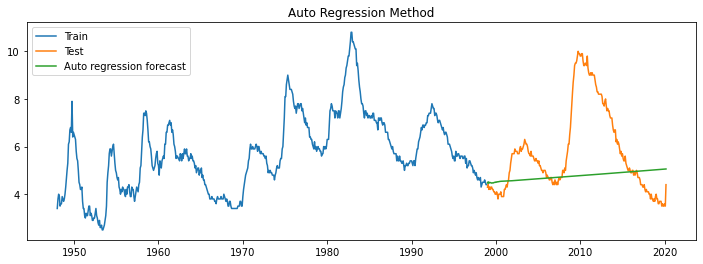

In [188]:
plt.figure(figsize=(12,4))
plt.plot(train['Unrate'], label='Train')
plt.plot(test['Unrate'], label='Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label='Auto regression forecast')
plt.legend(loc='best')
plt.title('Auto Regression Method')
plt.show()

In [189]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Unrate'], y_hat_ar['ar_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Unrate']-y_hat_ar['ar_forecast'][test.index.min():])/test['Unrate'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive (AR) method'], 'RMSE': [rmse],'MAPE': [mape] })
#results = pd.concat([results, tempResults])
results = tempResults[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Autoregressive (AR) method,2.07,21.5


## Simple moving average method

In [190]:
y_hat_sma = data.copy()
ma_window = 5
y_hat_sma['sma_forecast'] = data['Unrate'].rolling(ma_window).mean()
y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len-1]

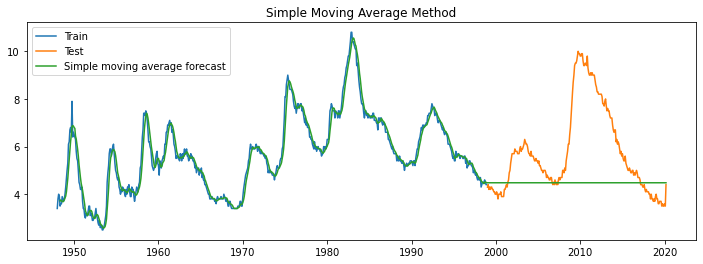

In [191]:
plt.figure(figsize=(12,4))
plt.plot(train['Unrate'], label='Train')
plt.plot(test['Unrate'], label='Test')
plt.plot(y_hat_sma['sma_forecast'], label='Simple moving average forecast')
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

In [192]:
rmse = np.sqrt(mean_squared_error(test['Unrate'], y_hat_sma['sma_forecast'][train_len:])).round(2)
mape = np.round(np.mean(np.abs(test['Unrate']-y_hat_sma['sma_forecast'][train_len:])/test['Unrate'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple moving average forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Autoregressive (AR) method,2.07,21.50
0,Simple moving average forecast,2.22,22.09


In [193]:
y_hat_sma['sma_forecast'][6]

3.72

## Moving average method (MA)

In [194]:
model = ARIMA(train_data_boxcox_diff, order=(0, 0, 5)) 
model_fit = model.fit()
print(model_fit.params)

const      0.000507
ma.L1.y    0.055504
ma.L2.y    0.181882
ma.L3.y    0.123451
ma.L4.y    0.099834
ma.L5.y    0.151700
dtype: float64


In [195]:
y_hat_ma = data_boxcox_diff.copy()
y_hat_ma['ma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox_diff'].cumsum()
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox'].add(data_boxcox[0])
y_hat_ma['ma_forecast'] = np.exp(y_hat_ma['ma_forecast_boxcox'])

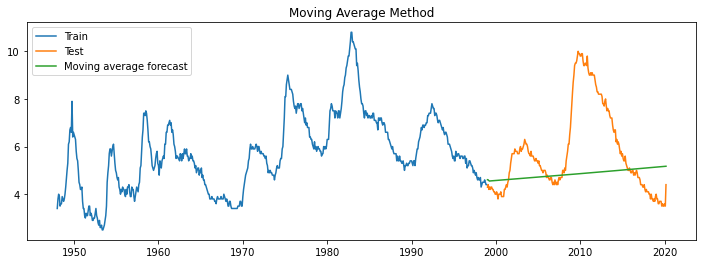

In [196]:
plt.figure(figsize=(12,4))
plt.plot(data['Unrate'][:train_len], label='Train')
plt.plot(data['Unrate'][train_len:], label='Test')
plt.plot(y_hat_ma['ma_forecast'][test.index.min():], label='Moving average forecast')
plt.legend(loc='best')
plt.title('Moving Average Method')
plt.show()

In [197]:
rmse = np.sqrt(mean_squared_error(test['Unrate'], y_hat_ma['ma_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Unrate']-y_hat_ma['ma_forecast'][test.index.min():])/test['Unrate'])*100,2)

tempResults = pd.DataFrame({'Method':['Moving Average (MA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Autoregressive (AR) method,2.07,21.50
0,Simple moving average forecast,2.22,22.09
0,Moving Average (MA) method,2.03,21.60


In [198]:
y_hat_ma['ma_forecast']

1948-02-01    3.401726
1948-03-01    3.443834
1948-04-01    3.537628
1948-05-01    3.611959
1948-06-01    3.610562
                ...   
2019-11-01    5.162573
2019-12-01    5.165194
2020-01-01    5.167816
2020-02-01    5.170439
2020-03-01    5.173063
Freq: MS, Length: 866, dtype: float64

### What is the RMSE and MAPE value for the ARIMA(12, 1, 5)  process?

In [199]:
model = ARIMA(train_data_boxcox_diff, order=(12, 1, 5)) 
model_fit = model.fit()
print(model_fit.params)

const        -0.000013
ar.L1.D.y     0.635739
ar.L2.D.y     0.466816
ar.L3.D.y    -0.238295
ar.L4.D.y    -0.383419
ar.L5.D.y     0.075425
ar.L6.D.y     0.013119
ar.L7.D.y    -0.001374
ar.L8.D.y     0.107663
ar.L9.D.y     0.044342
ar.L10.D.y   -0.153404
ar.L11.D.y    0.105807
ar.L12.D.y   -0.101825
ma.L1.D.y    -1.601870
ma.L2.D.y     0.265597
ma.L3.D.y     0.601991
ma.L4.D.y     0.122190
ma.L5.D.y    -0.387815
dtype: float64


In [200]:
y_hat_ma = data_boxcox_diff.copy()
y_hat_ma['ma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox_diff'].cumsum()
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox'].add(data_boxcox[0])
y_hat_ma['ma_forecast'] = np.exp(y_hat_ma['ma_forecast_boxcox'])

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

In [ ]:
rmse = np.sqrt(mean_squared_error(test['Unrate'], y_hat_ma['ma_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Unrate']-y_hat_ma['ma_forecast'][test.index.min():])/test['Unrate'])*100,2)

tempResults = pd.DataFrame({'Method':['ARIMA method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data_boxcox, order=(2, 1, 4), seasonal_order=(2, 1, 4, 12)) 
model_fit = model.fit()
print(model_fit.params)

In [ ]:
data.columns